In [ ]:
import pandas as pd
import numpy as np
import seaborn as sns
import math
import numpy as np
import pandas as pd
import datetime as dt
import seaborn as sns
import lightgbm as lgb
import matplotlib.pyplot as plt
from sklearn import metrics
from datetime import datetime
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.metrics import accuracy_score, confusion_matrix, precision_score, recall_score, f1_score, roc_auc_score, roc_curve


/usr/local/lib/python3.10/dist-packages/dask/dataframe/__init__.py:42: FutureWarning: 
Dask dataframe query planning is disabled because dask-expr is not installed.

You can install it with `pip install dask[dataframe]` or `conda install dask`.
This will raise in a future version.

  warnings.warn(msg, FutureWarning)


In [ ]:
caminho = r"/content/drive/MyDrive/8ºSEMESTRE/TG/LightGBM/base.parquet"
base = pd.read_parquet(caminho)

In [ ]:
base['var_325'] = base['var_325'].astype('category')
base['var_1'] = base['var_1'].astype('category')
base['var_339'] = base['var_339'].astype('category')
base['CAT_var_275'] = base['CAT_var_275'].astype('category')
base['var_365'] = base['var_365'].astype('category')
# base['var_resposta'] = base['var_resposta'].astype('category')

In [ ]:
base.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 411471 entries, 0 to 411470
Columns: 218 entries, id to split
dtypes: category(5), float64(132), int32(78), object(3)
memory usage: 548.2+ MB


In [ ]:
#base.columns.tolist()
base.shape

(411471, 218)

In [ ]:
# df_numerico = base.select_dtypes(include=['float64', 'int32'])
# df_numerico = df_numerico.drop(df_numerico.columns[:2],axis=1)
# print(df_numerico.columns)
# print(df_numerico.shape)

Index(['var_3', 'var_4', 'var_53', 'var_64', 'var_66', 'var_213', 'var_222',
       'var_223', 'var_249', 'var_250',
       ...
       'var_231', 'var_232', 'var_233', 'var_236', 'var_239', 'var_240',
       'var_241', 'var_242', 'var_243', 'var_244'],
      dtype='object', length=207)
(411471, 207)


In [ ]:
correlacao = df_numerico.corr(min_periods = 3 )

In [ ]:
corr_spearman = df_numerico.corr(method="spearman")

,var_2,var_3,var_4,var_53,var_64,var_66,var_213,var_222,var_223,var_249,...,var_231,var_232,var_233,var_236,var_239,var_240,var_241,var_242,var_243,var_244
var_2,1.000000,0.232968,0.230477,-0.042406,0.069725,0.026886,-0.057437,-0.005528,-0.021622,0.581335,...,-0.068521,0.123850,-0.087980,0.012798,-0.087159,-0.052505,-0.009498,-0.095531,-0.095285,-0.101774
var_3,0.232968,1.000000,0.980215,-0.012371,0.509910,-0.058887,0.177394,-0.237204,-0.341876,0.145409,...,0.061522,0.029670,0.014701,0.033289,0.198304,0.361073,0.525496,-0.021748,-0.014179,-0.022900
var_4,0.230477,0.980215,1.000000,-0.012714,0.500913,-0.057558,0.168396,-0.232512,-0.335968,0.143255,...,0.060961,0.026610,0.016641,0.033883,0.190582,0.351536,0.515360,-0.022397,-0.015000,-0.023744
var_53,-0.042406,-0.012371,-0.012714,1.000000,0.006926,-0.020043,0.018382,-0.075651,-0.066945,-0.030629,...,0.023667,-0.005848,-0.003445,-0.004280,0.038827,0.027835,0.019279,-0.047532,-0.053209,-0.052945
var_64,0.069725,0.509910,0.500913,0.006926,1.000000,-0.050671,0.276732,-0.316014,-0.380071,0.053215,...,0.073669,0.027858,0.012133,-0.000641,0.365493,0.544979,0.629700,0.000821,0.004814,0.001489
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
var_240,-0.052505,0.361073,0.351536,0.027835,0.544979,-0.086282,0.518328,-0.247411,-0.284256,-0.007640,...,0.027857,0.010951,0.024404,0.082883,0.916246,1.000000,0.933647,0.525182,0.531631,0.513835
var_241,-0.009498,0.525496,0.515360,0.019279,0.629700,-0.088682,0.523728,-0.276444,-0.351646,0.018112,...,0.057390,0.013141,0.029048,0.010828,0.797035,0.933647,1.000000,0.431217,0.450154,0.458961
var_242,-0.095531,-0.021748,-0.022397,-0.047532,0.000821,0.007350,0.385007,0.360317,0.312749,-0.029884,...,-0.035527,-0.033542,0.041869,0.313671,0.597756,0.525182,0.431217,1.000000,0.937552,0.899817
var_243,-0.095285,-0.014179,-0.015000,-0.053209,0.004814,0.009541,0.402134,0.399106,0.343837,-0.027690,...,-0.042079,-0.039661,0.049316,0.115832,0.544644,0.531631,0.450154,0.937552,1.000000,0.969030


In [ ]:
#df_numerico.corr(method="kendall") #demorou mt

KeyboardInterrupt: 

In [ ]:
# mask = (correlacao.abs() < 0.7)

# # Selecionar apenas variáveis que têm correlação abaixo de 0.7
# filtered_corr_matrix = correlacao[mask]

# # Para obter os nomes das variáveis que atendem à condição, você pode usar:
# selected_columns = filtered_corr_matrix.columns[filtered_corr_matrix.notna().any()].tolist()

# print("Variáveis com correlação abaixo de 0.7:")
# print(selected_columns)

Variáveis com correlação abaixo de 0.7:
['var_2', 'var_3', 'var_4', 'var_53', 'var_64', 'var_66', 'var_213', 'var_222', 'var_223', 'var_249', 'var_250', 'var_251', 'var_252', 'var_253', 'var_254', 'var_255', 'var_256', 'var_257', 'var_264', 'var_272', 'var_306', 'var_310', 'var_311', 'var_312', 'var_313', 'var_320', 'var_321', 'var_324', 'var_327', 'var_328', 'var_329', 'var_330', 'var_338', 'var_340', 'var_341', 'var_342', 'var_343', 'var_346', 'var_351', 'var_352', 'var_353', 'var_354', 'var_355', 'var_356', 'var_357', 'var_358', 'var_359', 'var_360', 'var_369', 'var_370', 'var_371', 'var_377', 'var_378', 'var_382', 'var_383', 'var_384', 'var_385', 'var_386', 'var_387', 'var_388', 'var_389', 'var_390', 'var_391', 'var_392', 'var_393', 'var_394', 'var_395', 'var_396', 'var_397', 'var_398', 'var_399', 'var_400', 'var_401', 'var_402', 'var_403', 'var_404', 'var_405', 'var_406', 'var_407', 'var_408', 'var_409', 'var_410', 'var_411', 'var_412', 'var_413', 'var_414', 'var_415', 'var_416', 

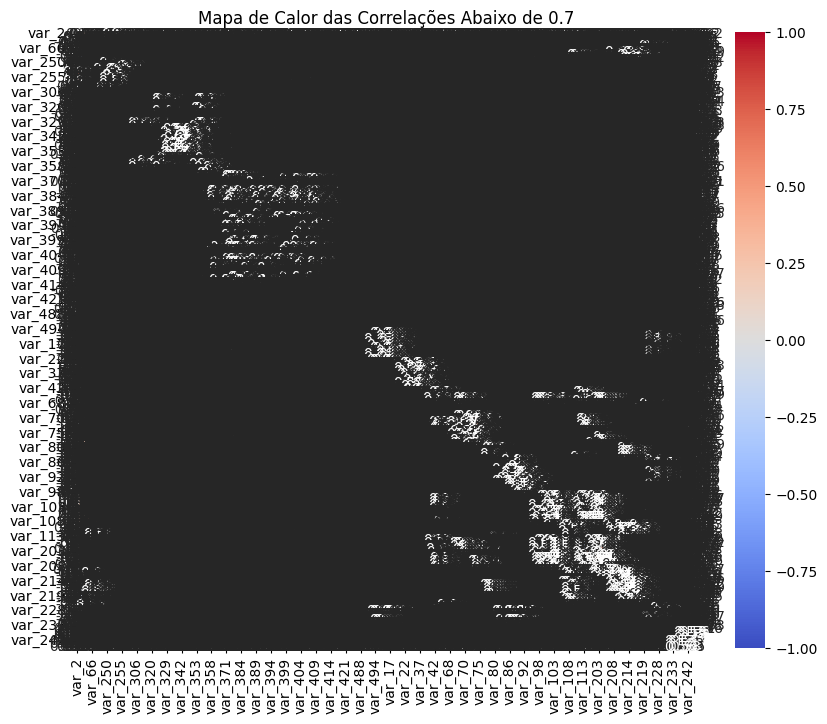

In [ ]:
# import pandas as pd
# import seaborn as sns
# import matplotlib.pyplot as plt


# plt.figure(figsize=(10, 8))
# sns.heatmap(filtered_corr_matrix, annot=True, cmap='coolwarm', vmin=-1, vmax=1, center=0)
# plt.title('Mapa de Calor das Correlações Abaixo de 0.7')
# plt.show()

In [ ]:
# base_processo = base.copy()

# cs = MinMaxScaler()
# Data_Continuous = cs.fit_transform(df_numerico)


In [ ]:
# Data_Continuous_df = pd.DataFrame(Data_Continuous, columns= df_numerico.columns)
# print(Data_Continuous_df.head())

      var_3     var_4  var_53    var_64  var_66   var_213   var_222   var_223  \
0  0.151203  0.014007     0.0  0.357143     0.5  0.015165  0.019591  0.009795   
1  0.268041  0.024361     0.0  0.178571     0.5  0.007082  0.014360  0.014372   
2  0.281787  0.025579     0.0  0.178571     0.5  0.004870  0.016321  0.016334   
3  0.274914  0.024970     0.0  0.357143     0.5  0.014966  0.006506  0.006519   
4  0.250859  0.022838     0.0  0.357143     0.5  0.024180  0.013058  0.013071   

   var_249   var_250  ...   var_231   var_232   var_233   var_236  \
0    0.639  0.044650  ...  0.000000  1.000000  0.000000  0.064381   
1    0.813  0.030793  ...  0.000000  0.172414  0.827586  0.037225   
2    0.371  0.066205  ...  0.030303  0.742424  0.227273  0.073703   
3    0.466  0.023095  ...  0.003521  0.992958  0.003521  0.078486   
4    0.836  0.027714  ...  0.015385  0.638462  0.346154  0.092922   

        var_239       var_240       var_241       var_242       var_243  \
0  9.032177e-08  1.4435

In [ ]:
# base_norma = base.drop(columns=df_numerico.columns)
# base_norma["var_resposta"] = 1-base_norma['var_resposta']
# base_norma["var_resposta"]= base_norma["var_resposta"].astype('category')

In [ ]:
base["var_resposta"] = 1-base["var_resposta"]

base["var_resposta"]= base["var_resposta"].astype('category')

In [ ]:
# base_norma = pd.concat([base_norma, Data_Continuous_df], axis = 1)
# print(base_norma.columns)
base["var_resposta"]

,var_resposta
0,1
1,1
2,1
3,1
4,1
...,...
411466,1
411467,1
411468,0
411469,1


In [ ]:
treino = base[base['split'] == "Treinamento"]
import random
np.random.seed(290)
split = np.random.choice(['Treinamento', 'Validacao'], size = len(treino), p = [0.8, 0.2])

# Adicionando a coluna 'split' na base de dados
treino['split'] = split
print(treino['split'].value_counts())

split
Treinamento    263227
Validacao       65774
Name: count, dtype: int64


<ipython-input-151-edcd998e3244>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  treino['split'] = split


In [ ]:
treinof = treino[treino['split'] == "Treinamento"]
treinof = treinof.drop(columns = ["id","amostra","foto","split"])

X_treino = treinof.drop(["var_resposta"],axis=1)
Y_treino = treinof["var_resposta"]


In [ ]:
valid = treino[treino['split'] == "Validacao"]
valid = valid.drop(columns = ["id","amostra","foto","split"])


X_valid = valid.drop(["var_resposta"],axis=1)
Y_valid = valid["var_resposta"]



In [ ]:
teste = base[base['split'] == "Teste"]
teste = teste.drop(columns = ["id","amostra","foto","split"])
X_teste = teste.drop(["var_resposta"],axis=1)
Y_teste = teste["var_resposta"]

In [ ]:
!pip install optuna

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 380.1/380.1 kB 19.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 233.0/233.0 kB 13.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 78.6/78.6 kB 4.9 MB/s eta 0:00:00


In [ ]:
import lightgbm as lgb
import optuna
from sklearn import metrics

def objective(trial):
    params = {
        "objective": "binary",
        "metric": "logloss",
        "learning_rate": trial.suggest_float("learning_rate", 0.001, 4, log=True),
        "num_leaves": trial.suggest_int("num_leaves", 50, 150),
        "colsample_bytree": trial.suggest_float("colsample_bytree", 0.05, 1.0),
        "min_child_samples": trial.suggest_int("min_child_samples", 5, 50),
        "max_depth": trial.suggest_int("max_depth", 5, 15),
        "n_estimators": trial.suggest_int("n_estimators", 50, 200),
         "min_split_gain":trial.suggest_int("min_split_gain", 0.001, 0.1)
    }

    class_lgbm = lgb.LGBMClassifier(**params)
    class_lgbm.fit(X_treino, Y_treino)
    predicoes = class_lgbm.predict_proba(X_valid)[:, 1]
    auc = metrics.roc_auc_score(Y_valid, predicoes)
    return auc


In [ ]:
# Criando o estudo e otimizando
study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=30)

[I 2024-09-01 21:43:39,965] A new study created in memory with name: no-name-037b73cb-e691-4a0d-ae5c-19f7d40b76bc


[LightGBM] [Info] Number of positive: 249123, number of negative: 14104
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 1.433165 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 42336
[LightGBM] [Info] Number of data points in the train set: 263227, number of used features: 213
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.946419 -> initscore=2.871488
[LightGBM] [Info] Start training from score 2.871488


[I 2024-09-01 21:45:13,567] Trial 0 finished with value: 0.8108965051730075 and parameters: {'learning_rate': 0.010888939653425894, 'num_leaves': 61, 'colsample_bytree': 0.9069261403220724, 'min_child_samples': 41, 'max_depth': 11, 'n_estimators': 197, 'min_split_gain': 0}. Best is trial 0 with value: 0.8108965051730075.


[LightGBM] [Info] Number of positive: 249123, number of negative: 14104
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.973179 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 42336
[LightGBM] [Info] Number of data points in the train set: 263227, number of used features: 213
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.946419 -> initscore=2.871488
[LightGBM] [Info] Start training from score 2.871488


[I 2024-09-01 21:46:19,086] Trial 1 finished with value: 0.7912231002435266 and parameters: {'learning_rate': 0.17942824785837458, 'num_leaves': 132, 'colsample_bytree': 0.6362870751657207, 'min_child_samples': 22, 'max_depth': 11, 'n_estimators': 187, 'min_split_gain': 0}. Best is trial 0 with value: 0.8108965051730075.


[LightGBM] [Info] Number of positive: 249123, number of negative: 14104
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.166813 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 42336
[LightGBM] [Info] Number of data points in the train set: 263227, number of used features: 213
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.946419 -> initscore=2.871488
[LightGBM] [Info] Start training from score 2.871488


[I 2024-09-01 21:46:55,947] Trial 2 finished with value: 0.792936370489673 and parameters: {'learning_rate': 0.002120859110627009, 'num_leaves': 117, 'colsample_bytree': 0.08160212276434685, 'min_child_samples': 37, 'max_depth': 12, 'n_estimators': 100, 'min_split_gain': 0}. Best is trial 0 with value: 0.8108965051730075.


[LightGBM] [Info] Number of positive: 249123, number of negative: 14104
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.275876 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 42336
[LightGBM] [Info] Number of data points in the train set: 263227, number of used features: 213
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.946419 -> initscore=2.871488
[LightGBM] [Info] Start training from score 2.871488
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best g

[I 2024-09-01 21:47:41,186] Trial 3 finished with value: 0.7966099921482358 and parameters: {'learning_rate': 0.2658677065725145, 'num_leaves': 121, 'colsample_bytree': 0.3262413750520221, 'min_child_samples': 33, 'max_depth': 7, 'n_estimators': 103, 'min_split_gain': 0}. Best is trial 0 with value: 0.8108965051730075.


[LightGBM] [Info] Number of positive: 249123, number of negative: 14104
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.366127 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 42336
[LightGBM] [Info] Number of data points in the train set: 263227, number of used features: 213
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.946419 -> initscore=2.871488
[LightGBM] [Info] Start training from score 2.871488


[I 2024-09-01 21:48:14,056] Trial 4 finished with value: 0.7541567290784527 and parameters: {'learning_rate': 0.5243294320630778, 'num_leaves': 121, 'colsample_bytree': 0.848925372988294, 'min_child_samples': 27, 'max_depth': 9, 'n_estimators': 71, 'min_split_gain': 0}. Best is trial 0 with value: 0.8108965051730075.


[LightGBM] [Info] Number of positive: 249123, number of negative: 14104
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.994695 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 42336
[LightGBM] [Info] Number of data points in the train set: 263227, number of used features: 213
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.946419 -> initscore=2.871488
[LightGBM] [Info] Start training from score 2.871488
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive g

[I 2024-09-01 21:48:53,458] Trial 5 finished with value: 0.8142172320828948 and parameters: {'learning_rate': 0.09580582209309287, 'num_leaves': 58, 'colsample_bytree': 0.6411208093301627, 'min_child_samples': 12, 'max_depth': 6, 'n_estimators': 126, 'min_split_gain': 0}. Best is trial 5 with value: 0.8142172320828948.


[LightGBM] [Info] Number of positive: 249123, number of negative: 14104
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 1.611316 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 42336
[LightGBM] [Info] Number of data points in the train set: 263227, number of used features: 213
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.946419 -> initscore=2.871488
[LightGBM] [Info] Start training from score 2.871488
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves 

[I 2024-09-01 21:49:16,809] Trial 6 finished with value: 0.36676252218036925 and parameters: {'learning_rate': 3.1467694170628655, 'num_leaves': 83, 'colsample_bytree': 0.9655512659077552, 'min_child_samples': 31, 'max_depth': 15, 'n_estimators': 109, 'min_split_gain': 0}. Best is trial 5 with value: 0.8142172320828948.


[LightGBM] [Info] Number of positive: 249123, number of negative: 14104
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.196479 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 42336
[LightGBM] [Info] Number of data points in the train set: 263227, number of used features: 213
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.946419 -> initscore=2.871488
[LightGBM] [Info] Start training from score 2.871488


[I 2024-09-01 21:49:48,384] Trial 7 finished with value: 0.8061639398488959 and parameters: {'learning_rate': 0.15511275614145456, 'num_leaves': 89, 'colsample_bytree': 0.2837177943219751, 'min_child_samples': 9, 'max_depth': 14, 'n_estimators': 60, 'min_split_gain': 0}. Best is trial 5 with value: 0.8142172320828948.


[LightGBM] [Info] Number of positive: 249123, number of negative: 14104
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 1.006153 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 42336
[LightGBM] [Info] Number of data points in the train set: 263227, number of used features: 213
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.946419 -> initscore=2.871488
[LightGBM] [Info] Start training from score 2.871488
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves 

[I 2024-09-01 21:50:14,759] Trial 8 finished with value: 0.4411625280605451 and parameters: {'learning_rate': 3.691977211678725, 'num_leaves': 63, 'colsample_bytree': 0.6647370812316697, 'min_child_samples': 7, 'max_depth': 15, 'n_estimators': 159, 'min_split_gain': 0}. Best is trial 5 with value: 0.8142172320828948.


[LightGBM] [Info] Number of positive: 249123, number of negative: 14104
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.173896 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 42336
[LightGBM] [Info] Number of data points in the train set: 263227, number of used features: 213
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.946419 -> initscore=2.871488
[LightGBM] [Info] Start training from score 2.871488


[I 2024-09-01 21:50:54,843] Trial 9 finished with value: 0.7986336328217944 and parameters: {'learning_rate': 0.007715713604787819, 'num_leaves': 60, 'colsample_bytree': 0.12265951465331688, 'min_child_samples': 14, 'max_depth': 10, 'n_estimators': 101, 'min_split_gain': 0}. Best is trial 5 with value: 0.8142172320828948.


[LightGBM] [Info] Number of positive: 249123, number of negative: 14104
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 1.473022 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 42336
[LightGBM] [Info] Number of data points in the train set: 263227, number of used features: 213
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.946419 -> initscore=2.871488
[LightGBM] [Info] Start training from score 2.871488
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive g

[I 2024-09-01 21:51:33,228] Trial 10 finished with value: 0.8128982294481026 and parameters: {'learning_rate': 0.03820944151405359, 'num_leaves': 50, 'colsample_bytree': 0.4748979576267175, 'min_child_samples': 49, 'max_depth': 5, 'n_estimators': 150, 'min_split_gain': 0}. Best is trial 5 with value: 0.8142172320828948.


[LightGBM] [Info] Number of positive: 249123, number of negative: 14104
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.234430 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 42336
[LightGBM] [Info] Number of data points in the train set: 263227, number of used features: 213
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.946419 -> initscore=2.871488
[LightGBM] [Info] Start training from score 2.871488
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best g

[I 2024-09-01 21:52:35,622] Trial 11 finished with value: 0.8127540195007019 and parameters: {'learning_rate': 0.039596704155627445, 'num_leaves': 50, 'colsample_bytree': 0.47045918216219046, 'min_child_samples': 46, 'max_depth': 5, 'n_estimators': 146, 'min_split_gain': 0}. Best is trial 5 with value: 0.8142172320828948.


[LightGBM] [Info] Number of positive: 249123, number of negative: 14104
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.222690 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 42336
[LightGBM] [Info] Number of data points in the train set: 263227, number of used features: 213
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.946419 -> initscore=2.871488
[LightGBM] [Info] Start training from score 2.871488
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best g

[I 2024-09-01 21:53:37,675] Trial 12 finished with value: 0.8120748000239575 and parameters: {'learning_rate': 0.03727455728626902, 'num_leaves': 78, 'colsample_bytree': 0.48437671117656966, 'min_child_samples': 49, 'max_depth': 5, 'n_estimators': 142, 'min_split_gain': 0}. Best is trial 5 with value: 0.8142172320828948.


[LightGBM] [Info] Number of positive: 249123, number of negative: 14104
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 1.001444 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 42336
[LightGBM] [Info] Number of data points in the train set: 263227, number of used features: 213
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.946419 -> initscore=2.871488
[LightGBM] [Info] Start training from score 2.871488
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive g

[I 2024-09-01 21:54:46,596] Trial 13 finished with value: 0.8126199951829891 and parameters: {'learning_rate': 0.016457984650541862, 'num_leaves': 99, 'colsample_bytree': 0.6964907828536379, 'min_child_samples': 20, 'max_depth': 7, 'n_estimators': 170, 'min_split_gain': 0}. Best is trial 5 with value: 0.8142172320828948.


[LightGBM] [Info] Number of positive: 249123, number of negative: 14104
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.200988 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 42336
[LightGBM] [Info] Number of data points in the train set: 263227, number of used features: 213
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.946419 -> initscore=2.871488
[LightGBM] [Info] Start training from score 2.871488
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best g

[I 2024-09-01 21:55:36,356] Trial 14 finished with value: 0.6593980069844838 and parameters: {'learning_rate': 0.9808832870286335, 'num_leaves': 149, 'colsample_bytree': 0.3420288450748924, 'min_child_samples': 16, 'max_depth': 7, 'n_estimators': 129, 'min_split_gain': 0}. Best is trial 5 with value: 0.8142172320828948.


[LightGBM] [Info] Number of positive: 249123, number of negative: 14104
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 1.030674 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 42336
[LightGBM] [Info] Number of data points in the train set: 263227, number of used features: 213
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.946419 -> initscore=2.871488
[LightGBM] [Info] Start training from score 2.871488
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive g

[I 2024-09-01 21:56:21,270] Trial 15 finished with value: 0.8158772576097758 and parameters: {'learning_rate': 0.07819910494686104, 'num_leaves': 73, 'colsample_bytree': 0.7776870546561911, 'min_child_samples': 26, 'max_depth': 6, 'n_estimators': 131, 'min_split_gain': 0}. Best is trial 15 with value: 0.8158772576097758.


[LightGBM] [Info] Number of positive: 249123, number of negative: 14104
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 1.035449 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 42336
[LightGBM] [Info] Number of data points in the train set: 263227, number of used features: 213
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.946419 -> initscore=2.871488
[LightGBM] [Info] Start training from score 2.871488
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive g

[I 2024-09-01 21:57:12,746] Trial 16 finished with value: 0.8135827784031153 and parameters: {'learning_rate': 0.08959133473853038, 'num_leaves': 73, 'colsample_bytree': 0.8005466683563697, 'min_child_samples': 23, 'max_depth': 8, 'n_estimators': 127, 'min_split_gain': 0}. Best is trial 15 with value: 0.8158772576097758.


[LightGBM] [Info] Number of positive: 249123, number of negative: 14104
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.366537 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 42336
[LightGBM] [Info] Number of data points in the train set: 263227, number of used features: 213
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.946419 -> initscore=2.871488
[LightGBM] [Info] Start training from score 2.871488
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best g

[I 2024-09-01 21:57:52,685] Trial 17 finished with value: 0.7972388592058339 and parameters: {'learning_rate': 0.002455603026719827, 'num_leaves': 94, 'colsample_bytree': 0.6006196163675913, 'min_child_samples': 13, 'max_depth': 6, 'n_estimators': 81, 'min_split_gain': 0}. Best is trial 15 with value: 0.8158772576097758.


[LightGBM] [Info] Number of positive: 249123, number of negative: 14104
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.991733 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 42336
[LightGBM] [Info] Number of data points in the train set: 263227, number of used features: 213
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.946419 -> initscore=2.871488
[LightGBM] [Info] Start training from score 2.871488


[I 2024-09-01 21:58:35,490] Trial 18 finished with value: 0.761038744442278 and parameters: {'learning_rate': 0.5134662595643147, 'num_leaves': 70, 'colsample_bytree': 0.7964240985776422, 'min_child_samples': 27, 'max_depth': 9, 'n_estimators': 117, 'min_split_gain': 0}. Best is trial 15 with value: 0.8158772576097758.


[LightGBM] [Info] Number of positive: 249123, number of negative: 14104
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.987539 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 42336
[LightGBM] [Info] Number of data points in the train set: 263227, number of used features: 213
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.946419 -> initscore=2.871488
[LightGBM] [Info] Start training from score 2.871488
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive g

[I 2024-09-01 21:59:38,674] Trial 19 finished with value: 0.8109296539816891 and parameters: {'learning_rate': 0.09216750352397454, 'num_leaves': 110, 'colsample_bytree': 0.7108856145994382, 'min_child_samples': 6, 'max_depth': 8, 'n_estimators': 172, 'min_split_gain': 0}. Best is trial 15 with value: 0.8158772576097758.


[LightGBM] [Info] Number of positive: 249123, number of negative: 14104
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 1.127453 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 42336
[LightGBM] [Info] Number of data points in the train set: 263227, number of used features: 213
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.946419 -> initscore=2.871488
[LightGBM] [Info] Start training from score 2.871488
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive g

[I 2024-09-01 22:00:24,506] Trial 20 finished with value: 0.7963039499307577 and parameters: {'learning_rate': 0.005188806614376642, 'num_leaves': 68, 'colsample_bytree': 0.9788748853989311, 'min_child_samples': 18, 'max_depth': 6, 'n_estimators': 88, 'min_split_gain': 0}. Best is trial 15 with value: 0.8158772576097758.


[LightGBM] [Info] Number of positive: 249123, number of negative: 14104
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.364752 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 42336
[LightGBM] [Info] Number of data points in the train set: 263227, number of used features: 213
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.946419 -> initscore=2.871488
[LightGBM] [Info] Start training from score 2.871488
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best g

[I 2024-09-01 22:01:15,034] Trial 21 finished with value: 0.8146151315675693 and parameters: {'learning_rate': 0.08107053310152931, 'num_leaves': 77, 'colsample_bytree': 0.7892676564520766, 'min_child_samples': 23, 'max_depth': 8, 'n_estimators': 130, 'min_split_gain': 0}. Best is trial 15 with value: 0.8158772576097758.


[LightGBM] [Info] Number of positive: 249123, number of negative: 14104
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 1.017381 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 42336
[LightGBM] [Info] Number of data points in the train set: 263227, number of used features: 213
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.946419 -> initscore=2.871488
[LightGBM] [Info] Start training from score 2.871488
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive g

[I 2024-09-01 22:02:06,885] Trial 22 finished with value: 0.8103094092098118 and parameters: {'learning_rate': 0.020681726706459305, 'num_leaves': 84, 'colsample_bytree': 0.7605751517524144, 'min_child_samples': 12, 'max_depth': 6, 'n_estimators': 136, 'min_split_gain': 0}. Best is trial 15 with value: 0.8158772576097758.


[LightGBM] [Info] Number of positive: 249123, number of negative: 14104
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.969722 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 42336
[LightGBM] [Info] Number of data points in the train set: 263227, number of used features: 213
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.946419 -> initscore=2.871488
[LightGBM] [Info] Start training from score 2.871488
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive g

[I 2024-09-01 22:02:49,290] Trial 23 finished with value: 0.8143461726882033 and parameters: {'learning_rate': 0.08050330822272597, 'num_leaves': 78, 'colsample_bytree': 0.5654730092067151, 'min_child_samples': 24, 'max_depth': 8, 'n_estimators': 119, 'min_split_gain': 0}. Best is trial 15 with value: 0.8158772576097758.


[LightGBM] [Info] Number of positive: 249123, number of negative: 14104
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.958801 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 42336
[LightGBM] [Info] Number of data points in the train set: 263227, number of used features: 213
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.946419 -> initscore=2.871488
[LightGBM] [Info] Start training from score 2.871488
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


[I 2024-09-01 22:03:27,578] Trial 24 finished with value: 0.7857292728807564 and parameters: {'learning_rate': 0.30054552336987705, 'num_leaves': 79, 'colsample_bytree': 0.559388898072972, 'min_child_samples': 25, 'max_depth': 8, 'n_estimators': 117, 'min_split_gain': 0}. Best is trial 15 with value: 0.8158772576097758.


[LightGBM] [Info] Number of positive: 249123, number of negative: 14104
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 1.609425 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 42336
[LightGBM] [Info] Number of data points in the train set: 263227, number of used features: 213
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.946419 -> initscore=2.871488
[LightGBM] [Info] Start training from score 2.871488
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive g

[I 2024-09-01 22:04:42,294] Trial 25 finished with value: 0.8157079840954896 and parameters: {'learning_rate': 0.05627580378444304, 'num_leaves': 104, 'colsample_bytree': 0.8712110506138814, 'min_child_samples': 31, 'max_depth': 9, 'n_estimators': 154, 'min_split_gain': 0}. Best is trial 15 with value: 0.8158772576097758.


[LightGBM] [Info] Number of positive: 249123, number of negative: 14104
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 1.675230 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 42336
[LightGBM] [Info] Number of data points in the train set: 263227, number of used features: 213
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.946419 -> initscore=2.871488
[LightGBM] [Info] Start training from score 2.871488


[I 2024-09-01 22:06:06,742] Trial 26 finished with value: 0.8164518809553847 and parameters: {'learning_rate': 0.03013980947942617, 'num_leaves': 106, 'colsample_bytree': 0.8785094932417932, 'min_child_samples': 31, 'max_depth': 9, 'n_estimators': 160, 'min_split_gain': 0}. Best is trial 26 with value: 0.8164518809553847.


[LightGBM] [Info] Number of positive: 249123, number of negative: 14104
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 1.007527 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 42336
[LightGBM] [Info] Number of data points in the train set: 263227, number of used features: 213
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.946419 -> initscore=2.871488
[LightGBM] [Info] Start training from score 2.871488


[I 2024-09-01 22:07:38,815] Trial 27 finished with value: 0.8142142965461887 and parameters: {'learning_rate': 0.021261903188350875, 'num_leaves': 107, 'colsample_bytree': 0.8892139969029251, 'min_child_samples': 31, 'max_depth': 13, 'n_estimators': 159, 'min_split_gain': 0}. Best is trial 26 with value: 0.8164518809553847.


[LightGBM] [Info] Number of positive: 249123, number of negative: 14104
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 1.591588 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 42336
[LightGBM] [Info] Number of data points in the train set: 263227, number of used features: 213
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.946419 -> initscore=2.871488
[LightGBM] [Info] Start training from score 2.871488


[I 2024-09-01 22:09:17,582] Trial 28 finished with value: 0.7962372381524014 and parameters: {'learning_rate': 0.0011149839535068088, 'num_leaves': 103, 'colsample_bytree': 0.9072613759817358, 'min_child_samples': 37, 'max_depth': 10, 'n_estimators': 176, 'min_split_gain': 0}. Best is trial 26 with value: 0.8164518809553847.


[LightGBM] [Info] Number of positive: 249123, number of negative: 14104
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.282839 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 42336
[LightGBM] [Info] Number of data points in the train set: 263227, number of used features: 213
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.946419 -> initscore=2.871488
[LightGBM] [Info] Start training from score 2.871488


[I 2024-09-01 22:10:55,500] Trial 29 finished with value: 0.8125046058343359 and parameters: {'learning_rate': 0.010697731860765983, 'num_leaves': 131, 'colsample_bytree': 0.9009771072769692, 'min_child_samples': 42, 'max_depth': 11, 'n_estimators': 196, 'min_split_gain': 0}. Best is trial 26 with value: 0.8164518809553847.


In [ ]:
print('Melhores hiperparâmetros:', study.best_params)
print('Melhor AUC:', study.best_value)

#Melhores hiperparâmetros: {'learning_rate': 0.03013980947942617, 'num_leaves': 106, 'colsample_bytree': 0.8785094932417932, 'min_child_samples': 31, 'max_depth': 9, 'n_estimators': 160, 'min_split_gain': 0}
#Melhor AUC: 0.8164518809553847

Melhores hiperparâmetros: {'learning_rate': 0.03013980947942617, 'num_leaves': 106, 'colsample_bytree': 0.8785094932417932, 'min_child_samples': 31, 'max_depth': 9, 'n_estimators': 160, 'min_split_gain': 0}
Melhor AUC: 0.8164518809553847


In [ ]:
# class_lgbm = lgb.LGBMClassifier(learning_rate= 0.059471927330140534,
#                                 num_leaves= 84,
#                                 colsample_bytree= 0.788097629180493,
#                                 min_child_samples= 43,
#                                 max_depth= 8,
#                                 n_estimators= 134)

# Melhores hiperparâmetros: {'learning_rate': 0.03013980947942617,
# 'num_leaves': 106, 'colsample_bytree': 0.8785094932417932,
# 'min_child_samples': 31, 'max_depth': 9, 'n_estimators': 160, 'min_split_gain': 0}

class_lgbm = lgb.LGBMClassifier(**study.best_params)
class_lgbm.fit(X_treino,Y_treino)

[LightGBM] [Info] Number of positive: 249123, number of negative: 14104
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 1.020072 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 42336
[LightGBM] [Info] Number of data points in the train set: 263227, number of used features: 213
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.946419 -> initscore=2.871488
[LightGBM] [Info] Start training from score 2.871488


LGBMClassifier(colsample_bytree=0.8785094932417932,
               learning_rate=0.03013980947942617, max_depth=9,
               min_child_samples=31, min_split_gain=0, n_estimators=160,
               num_leaves=106)

In [ ]:
predicoes = class_lgbm.predict_proba(X_teste)[:, 1]
predicoes


array([0.98916329, 0.97848369, 0.84059345, ..., 0.98940431, 0.9960547 ,
       0.99217086])

# Curva ROC

In [ ]:
auc = metrics.roc_auc_score(Y_teste, predicoes)
auc #0.8139303693147568

0.8139303693147568

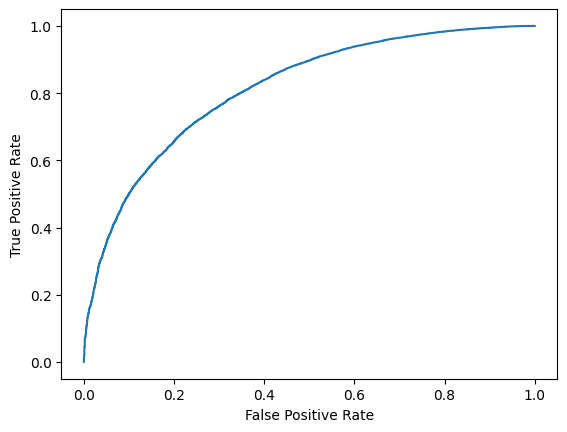

In [ ]:
fpr, tpr, corte = metrics.roc_curve(Y_teste,  predicoes)

#create ROC curve
plt.plot(fpr,tpr)
plt.ylabel('True Positive Rate') #sensibilidade
plt.xlabel('False Positive Rate') #especificidade
plt.show()

# Análise de Ponto de Corte

In [ ]:
Y_teste_p_maus = 1 - Y_teste.astype('int')

In [ ]:
Y_teste_p_maus.value_counts()

,count
var_resposta,
0,77984
1,4486


In [ ]:
# Calcular a especificidade
specificity = 1 - fpr

metric = tpr + specificity - 1
best_index = np.argmax(metric)
best_threshold = corte[best_index]


In [ ]:
print(f"Ponto de Corte Ideal: {best_threshold}")
print(f"Máxima Métrica (Sensibilidade + Especificidade - 1): {metric[best_index]}")

Ponto de Corte Ideal: 0.9447286727735171
Máxima Métrica (Sensibilidade + Especificidade - 1): 0.44273883998930863


In [ ]:
class_predicoes = np.where(predicoes < 0.944, 1, 0)

In [ ]:
np.bincount(class_predicoes)

array([59602, 22868])

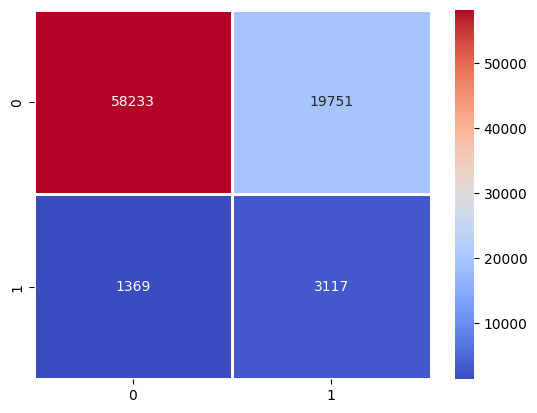

In [ ]:
cm = confusion_matrix(Y_teste_p_maus, class_predicoes)
sns.heatmap(cm, cmap='coolwarm', annot=True, linewidth=1, fmt='d')
plt.show()

In [ ]:
print(accuracy_score(Y_teste_p_maus, class_predicoes))
print(f1_score(Y_teste_p_maus, class_predicoes))
print(precision_score(Y_teste_p_maus, class_predicoes))

0.7439068752273554
0.22790085545075678
0.13630400559734127


In [ ]:
Y_teste = Y_teste.reset_index()
Y_teste.columns = ['Index', 'var_resposta']

In [ ]:
Y_teste["score"] = predicoes*1000

In [ ]:
Y_teste

,Index,var_resposta,score
0,1,1,989.163286
1,4,1,978.483693
2,8,1,840.593450
3,19,1,991.951067
4,28,1,990.379957
...,...,...,...
82465,411437,1,994.521839
82466,411445,1,986.006781
82467,411448,1,989.404307
82468,411454,1,996.054696


In [ ]:
 from scipy.stats import ks_2samp

 ks_2samp(Y_teste[Y_teste["var_resposta"]== 1 ]['score'],  Y_teste[Y_teste["var_resposta"]== 0 ]['score']) #0.4635352798685593


KstestResult(statistic=0.4635352798685593, pvalue=0.0, statistic_location=947.0421805525942, statistic_sign=-1)

In [ ]:
Y_teste["var_resposta"].value_counts()

,count
var_resposta,
1,77984
0,4486
